# PyFME Validation: comparing response versus Matlab model

In [1]:
from pyfme.aircrafts import LinearB747, Cessna172, SimplifiedCessna172
from pyfme.models import EulerFlatEarth
from pyfme.models.state import AircraftState
import numpy as np
# nl = np.linalg
import matplotlib.pyplot as plt
from pyfme.environment.atmosphere import SeaLevel
from pyfme.environment.wind import NoWind
from pyfme.environment.gravity import VerticalConstant
from pyfme.environment import Environment
from pyfme.utils.trimmer import steady_state_trim
from pyfme.models.state.position import EarthPosition
from pyfme.simulator import Simulation
from pyfme.utils.export import results2matlab
from scipy.io import savemat, loadmat
from pyfme.utils.coordinates import wind2body, body2wind
from pyfme.utils.input_generator import Constant, Doublet, Ramp
from json import load as jload
from copy import deepcopy as cp
plt.style.use('ggplot')
from scipy.interpolate import interp1d as itp
import pickle

In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

# Running a PyFME simulation and save it to a MATLAB readable file

We start by defining the airplane and the environment.

In [4]:
aircraft = SimplifiedCessna172()

In [5]:
aircraft.control_limits

{'delta_aileron': (-0.26179938779914941, 0.3490658503988659),
 'delta_elevator': (-0.4537856055185257, 0.48869219055841229),
 'delta_rudder': (-0.27925268031909273, 0.27925268031909273),
 'delta_t': (0, 1)}

In [129]:
atmosphere = SeaLevel()
gravity = VerticalConstant()
wind = NoWind()
environment = Environment(atmosphere, gravity, wind)

Generate a serie of states on which to test

In [130]:
pos = EarthPosition(x=0, y=0, height=1000)
psi = 0.5  # rad
TAS = 45  # m/s
controls0 = {'delta_elevator': 0, 'delta_aileron': 0, 'delta_rudder': 0, 'delta_t': 0.5}
tstate, cont = steady_state_trim(
    aircraft,
    environment,
    pos,
    psi,
    TAS,
    controls0
)

In [131]:
N = 100;
omega = np.random.normal(loc=1,scale=.5,size=(N,3)) * np.random.choice([-1,1],(N,3), replace=True)
euler = 60*np.pi/180*np.random.normal(loc=1,scale=.5,size=(N,3)) * np.random.choice([-1,1],(N,3), replace=True)
velocity = np.random.normal(loc=[50, 5, 5],scale=.5,size=(N,3)) * np.random.choice([-1,1],(N,3), replace=True)
velocity[:,0] *= np.sign(velocity[:,0])
states = []
for case_id in range(N):
    state = cp(tstate)
    state.velocity._vel_body = velocity[case_id, :]
    state.angular_vel._euler_ang_rate = omega[case_id, :]
    state.attitude._euler_angles = euler[case_id, :]
    states.append(state)
    state.save_to_json(f'{case_id}.json')

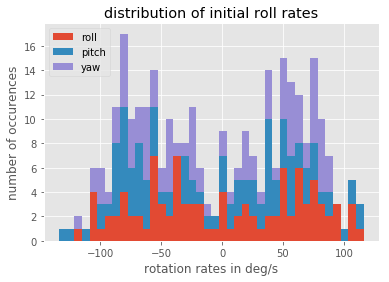

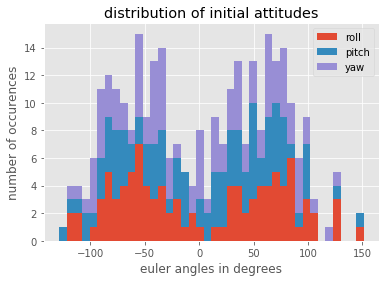

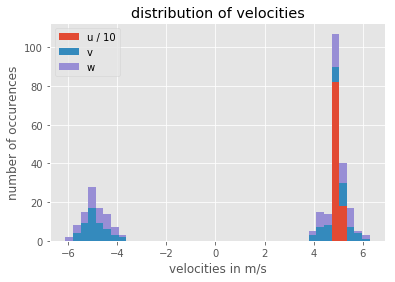

In [228]:
plt.hist(omega[:,:]*180/np.pi,40,stacked=True)
plt.xlabel('rotation rates in deg/s')
plt.ylabel('number of occurences')
plt.title('distribution of initial roll rates')
plt.legend(('roll','pitch','yaw'))
plt.show()

plt.hist(euler[:,:]*180/np.pi,40,stacked=True)
plt.xlabel('euler angles in degrees')
plt.ylabel('number of occurences')
plt.title('distribution of initial attitudes')
plt.legend(('roll','pitch','yaw'))
plt.show()

vel = velocity*1.0
vel[:,0]/=10
plt.hist(vel,40,stacked=True)
plt.xlabel('velocities in m/s')
plt.ylabel('number of occurences')
plt.title('distribution of velocities')
plt.legend(('u / 10','v','w'))
plt.show()

We finally pick a particular time serie of controls and run the simulation.

In [132]:
controls = {
    'delta_elevator': Doublet(t_init=2, T=1, A=0.1, offset=cont['delta_elevator']),
    'delta_aileron': Ramp(t_init=1,T=2, A=.2, offset=cont['delta_aileron']),
    'delta_rudder': Constant(cont['delta_rudder']),
    'delta_t': Constant(cont['delta_t'])
}

In [133]:
T = 3 # seconds

In [134]:
state

Aircraft State 
x_e: 0.00 m, y_e: 0.00 m, z_e: -1000.00 m 
theta: -1.018 rad, phi: -1.910 rad, psi: -1.009 rad 
u: 50.52 m/s, v: -3.92 m/s, w: -5.04 m/s 
P: 0.00 rad/s, Q: 0.00 rad/s, R: 0.00 rad/s 
u_dot: -0.00 m/s², v_dot: -0.00 m/s², w_dot: -0.00 m/s² 
P_dot: 0.00 rad/s², Q_dot: 0.00 rad/s², R_dot: -0.00 rad/s² 

In [141]:
results = {}
for case_id in range(N):
    state = states[case_id]
    environment.update(state)
    system = EulerFlatEarth(t0=0, full_state=state)
    sim = Simulation(aircraft, system, environment, controls, verbose=False)
    results[case_id] = sim.propagate(T)

In [242]:
with open('batch_results.pkl','wb') as f:
    pickle.dump(file=f,obj=results)
# r = pickle.load(open('batch_results.pkl','rb'))

In [136]:
nT = int(T/sim.dt)
t=  np.arange(nT)*sim.dt
controls4matlab = np.ones((nT,4));
for it in range(nT):
    controls4matlab[it,0] = controls['delta_aileron']._fun(t[it])
    controls4matlab[it,1] = controls['delta_elevator']._fun(t[it])
    controls4matlab[it,2] = controls['delta_rudder']._fun(t[it])
    controls4matlab[it,3] = controls['delta_t']._fun(t[it])
savemat('controls.mat',{'c': controls4matlab, 'dt':sim.dt})

We save the controls in a Matlab file

# Run the same simulation in Simulink

The simulink bloc diagram used for comparison uses exactly the same model to compute forces and moments (the method aircraft.compute_forces_and_moments() was translated directly to Matlab). The entire equations of motion integration is done with the %6DOF (Quaternion) % Simulink bloc from the aerospace blocset. Verifying against this tool allows to make sure that there are no mistake in the way the EulerFlatEarth equations of motion are written, and in the way they are integrated.

We run the Simulink model and load the results:

In [143]:
matlab_rslt = {}
for case_id in range(N):
    with open('../../matlab_comparison/results' + str(case_id) + '.json','r') as f:
        mat_states = jload(f)
    mat_states = {k:np.array(el) for k,el in mat_states.items()}
    matlab_rslt[case_id] = mat_states

# Compare outputs

In [256]:
getname={'Euler':['phi','theta','psi'], 'Omega_body':['p','q','r'], 'V_body':['u', 'v', 'w']}
unit = {'Euler':'deg', 'Omega_body':'deg/s', 'V_body':'m/s'} 
legend = {'Euler':('roll','pitch','yaw'), 'Omega_body':('roll','pitch','yaw'), 'V_body':('u','v','w')} 
factor = {'Euler':180/np.pi, 'Omega_body':180/np.pi, 'V_body':1}
name = {'Euler':'euler angles', 'Omega_body':'rotation rates', 'V_body':'velocities'} 
def getMSE(keyword, idx):
    name =  getname[keyword][idx]
    error = np.zeros(N)
    for case_id in range(N):
        nc = len(results[case_id].u)
        matlab_calc = itp(matlab_rslt[case_id]['t'], matlab_rslt[case_id][keyword][:,idx])
        error[case_id] = np.sum(abs(results[case_id][name] - matlab_calc(results[case_id].index)))/nc
    return error*factor[keyword]

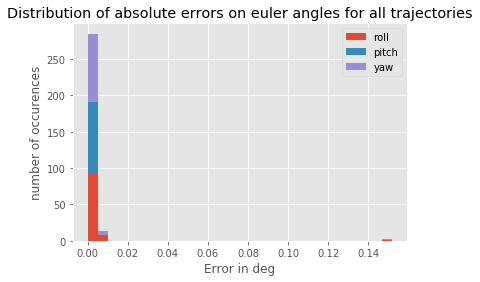

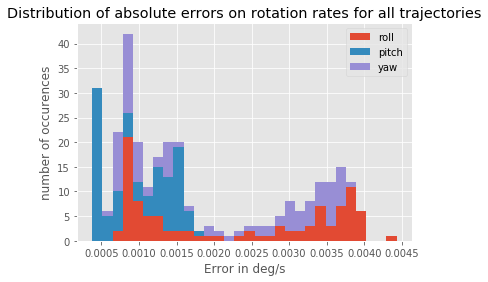

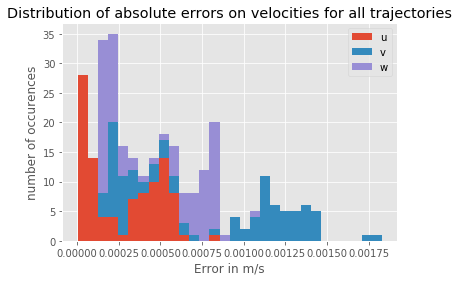

In [257]:
for keyword in getname.keys():
    err = (getMSE(keyword,i) for i in range(3))
    error = np.vstack(err)
    plt.hist(error.T, 30, stacked=True);
    plt.title('Distribution of absolute errors on ' + name[keyword] + ' for all trajectories')
    plt.ylabel('number of occurences')
    plt.xlabel('Error in ' + unit[keyword])
    plt.legend(legend[keyword])
    plt.show()

# Show examples

In [147]:
case_id=19

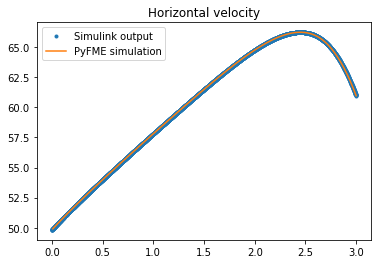

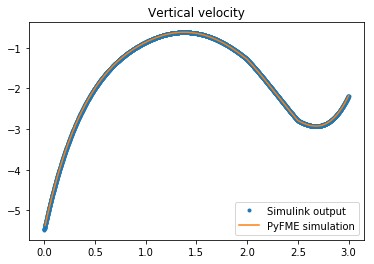

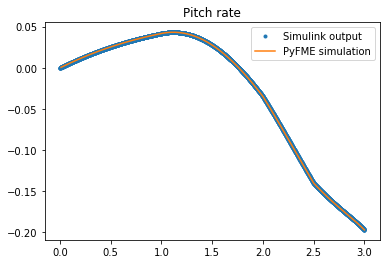

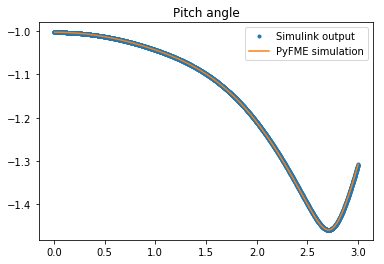

In [148]:
# Longitudinal values
plt.plot(matlab_rslt[case_id]['t'], matlab_rslt[case_id]['V_body'][:,0], '.', label='Simulink output')
plt.plot(results[case_id].u, label='PyFME simulation')
plt.legend()
plt.title("Horizontal velocity")
plt.show()

plt.plot(matlab_rslt[case_id]['t'], matlab_rslt[case_id]['V_body'][:,2], '.', label='Simulink output')
plt.plot(results[case_id].w, label='PyFME simulation')
plt.legend()
plt.title("Vertical velocity")
plt.show()

plt.plot(matlab_rslt[case_id]['t'], matlab_rslt[case_id]['Omega_body'][:,1], '.', label='Simulink output')
plt.plot(results[case_id].q, label='PyFME simulation')
plt.legend()
plt.title("Pitch rate")
plt.show()

plt.plot(matlab_rslt[case_id]['t'], matlab_rslt[case_id]['Euler'][:,1], '.', label='Simulink output')
plt.plot(results[case_id].theta, label='PyFME simulation')
plt.legend()
plt.title("Pitch angle")
plt.show()

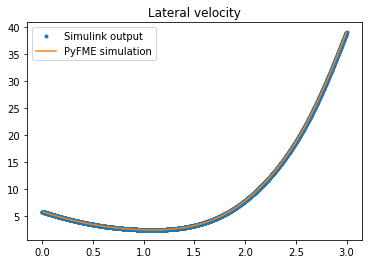

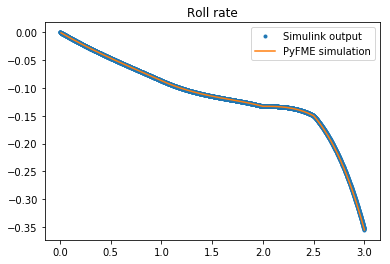

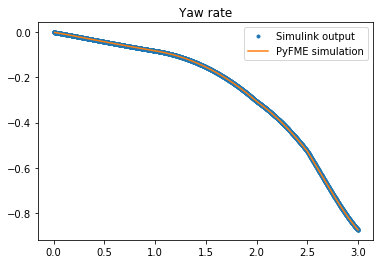

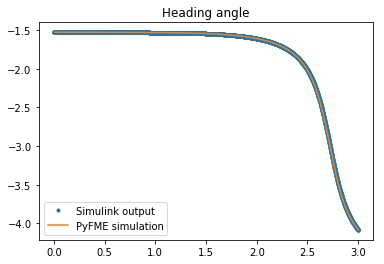

In [149]:
# Lateral case
plt.plot(matlab_rslt[case_id]['t'], matlab_rslt[case_id]['V_body'][:,1], '.', label='Simulink output')
plt.plot(results[case_id].v, label='PyFME simulation')
plt.legend()
plt.title("Lateral velocity")
plt.show()

plt.plot(matlab_rslt[case_id]['t'], matlab_rslt[case_id]['Omega_body'][:,0], '.', label='Simulink output')
plt.plot(results[case_id].p, label='PyFME simulation')
plt.legend()
plt.title("Roll rate")
plt.show()

plt.plot(matlab_rslt[case_id]['t'], matlab_rslt[case_id]['Omega_body'][:,2], '.', label='Simulink output')
plt.plot(results[case_id].r, label='PyFME simulation')
plt.legend()
plt.title("Yaw rate")
plt.show()

plt.plot(matlab_rslt[case_id]['t'], matlab_rslt[case_id]['Euler'][:,0], '.', label='Simulink output')
plt.plot(results[case_id].phi, label='PyFME simulation')
plt.legend()
plt.title("Heading angle")
plt.show()